# Exploratory data analysis for manually labeled dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Labeled dataset

In [ ]:
import pandas as pd
dataset_path = "/content/drive/MyDrive/MRP_Offensive_Content_Detection/Final_Dataset/"
dataset_name = "mrp_labeled_tweets_6.5K.csv"
df = pd.read_csv(dataset_path + dataset_name)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   type                       6499 non-null   object 
 1   id                         6499 non-null   int64  
 2   username                   6499 non-null   object 
 3   text                       6499 non-null   object 
 4   url                        6499 non-null   object 
 5   epoch                      6499 non-null   int64  
 6   media                      6499 non-null   object 
 7   retweetedTweet             6499 non-null   bool   
 8   retweetedTweetID           0 non-null      float64
 9   retweetedUserID            0 non-null      float64
 10  id_str                     6499 non-null   int64  
 11  lang                       6499 non-null   object 
 12  rawContent                 6499 non-null   object 
 13  replyCount                 6499 non-null   int64

In [ ]:
df.shape

(6499, 35)

# Language Filtering on Manually Labeled Dataset

In [ ]:
df['lang'].value_counts()

,count
lang,
en,6463
es,8
tl,7
fr,6
de,2
pt,2
in,2
zh,1
ca,1


In [ ]:
!pip install langdetect

In [ ]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0  # to make results reproducible

def detect_lang(text):
    try:
        return detect(text)
    except:
        return 'error'  # fallback if detection fails

# Apply on the dataset
df['detected_lang'] = df['text'].astype(str).apply(detect_lang)

# Filter for English tweets
df_en = df[df['detected_lang'] == 'en']
df_en.shape

(6499, 36)

Observation:
- Langdetect failed to identify the non-English tweets. Hence all rows with lang value other than “en” were removed from the labeled dataset

In [ ]:
df.drop(columns=['detected_lang'], inplace=True)

In [ ]:
df_labeled = df[df['lang'] == 'en']

In [ ]:
df_labeled.shape

(6463, 35)

# Creating new column with viewCount values

In [ ]:
df_labeled['viewCount'].head()

,viewCount
0,"{'count': '2626', 'state': 'EnabledWithCount'}"
1,"{'count': '3', 'state': 'EnabledWithCount'}"
3,"{'count': '2', 'state': 'EnabledWithCount'}"
4,"{'count': '16', 'state': 'EnabledWithCount'}"
5,"{'count': '5', 'state': 'EnabledWithCount'}"


# Create a column for View Counts
Since viewCount column contains dictionaries stored as objects, we need to extract the "count" value as a number and save to another column

In [ ]:
import ast
# Convert string to actual dictionary
df_labeled['viewCount_parsed'] = df_labeled['viewCount'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [ ]:
df_labeled['viewCount_num'] = df_labeled['viewCount_parsed'].apply(lambda x: int(x['count']) if isinstance(x, dict) and 'count' in x else None)
df_labeled['viewCount_num'] = pd.to_numeric(df_labeled['viewCount_num'], errors='coerce').astype('Int64')
top_views = df_labeled[['text', 'viewCount_num']].sort_values(by='viewCount_num', ascending=False)
print(top_views.head(10))

                                                                                                     text  \
1579  BREAKING Multibillionaire owner Arthur Blank announces his support for Kamala Harris to be the n...   
4881  Kamala Harris depicted chained up behind golf cart during Pennsylvania Halloween parade CBS Pitt...   
5266  Feminist author and exClinton advisor endorses Donald Trump for president The people I voted for...   
5483  gtHarris lies saying she worked at McDonalds gthe works a McDonalds gtBiden calls his supporters...   
2987  IRS Whistleblowers Involved in Hunter Biden Tax Case Reveal IRS DOJ and FBI Knew Laptop Was Real...   
5503  Anyone catch Bidens panda eyes Halloween gig tonight There is a reason Trump says these people a...   
4793  If you are a journalist covering this election fairly you have a duty to report on Donald Trumps...   
2075  Donald Trump would walk into that office with an enemies list I will walk in with a todo list fu...   
1826            Bid

In [ ]:
df_labeled.drop(columns=['viewCount_parsed'], inplace=True)

# 1.1 Dataset Overview

In [ ]:
df_labeled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6463 entries, 0 to 6498
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   type                       6463 non-null   object 
 1   id                         6463 non-null   int64  
 2   username                   6463 non-null   object 
 3   text                       6463 non-null   object 
 4   url                        6463 non-null   object 
 5   epoch                      6463 non-null   int64  
 6   media                      6463 non-null   object 
 7   retweetedTweet             6463 non-null   bool   
 8   retweetedTweetID           0 non-null      float64
 9   retweetedUserID            0 non-null      float64
 10  id_str                     6463 non-null   int64  
 11  lang                       6463 non-null   object 
 12  rawContent                 6463 non-null   object 
 13  replyCount                 6463 non-null   int64  
 1

In [ ]:
df_labeled['annotator1'].value_counts()

,count
annotator1,
Offensive,3527
Non-offensive,2936


In [ ]:
df_labeled['annotator2'].value_counts()

,count
annotator2,
Non-offensive,3413
Offensive,3050


In [ ]:
df_labeled['annotator3'].value_counts()

,count
annotator3,
Offensive,4102
Non-offensive,2361


In [ ]:
df_labeled = df_labeled.copy()

In [ ]:
annotator_cols = ['annotator1', 'annotator2', 'annotator3']
df_labeled['majority_label'] = df_labeled[annotator_cols].mode(axis=1)[0]

In [ ]:
df_labeled['majority_label'].value_counts()

,count
majority_label,
Offensive,3584
Non-offensive,2879


In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Annotator agreement

In [ ]:
import pandas as pd
from statsmodels.stats.inter_rater import fleiss_kappa

# Step 1: Define and map label strings to integers
label_list = ['Offensive', 'Non-offensive']
label_to_int = {label: idx for idx, label in enumerate(label_list)}

# Step 2: Convert string labels to integers
data = df_labeled[['annotator1', 'annotator2', 'annotator3']].replace(label_to_int).values.tolist()

# Step 3: Build Fleiss Kappa format table
n_items = len(data)
n_categories = len(label_list)
fleiss_table = [[0] * n_categories for _ in range(n_items)]

for i, item in enumerate(data):
    for label in item:
        fleiss_table[i][label] += 1

# Step 4: Compute Fleiss' Kappa
kappa = fleiss_kappa(fleiss_table)
print(f"Fleiss' Kappa: {kappa:.3f}")

Fleiss' Kappa: 0.594


In [ ]:
import pandas as pd

kappa_data = {
    'Annotator Pair': ['Annotator 1 & 2', 'Annotator 1 & 3', 'Annotator 2 & 3'],
    'Cohen\'s Kappa': [0.63, 0.59, 0.57]
}

kappa_df = pd.DataFrame(kappa_data)
display(kappa_df)


,Annotator Pair,Cohen's Kappa
0,Annotator 1 & 2,0.63
1,Annotator 1 & 3,0.59
2,Annotator 2 & 3,0.57


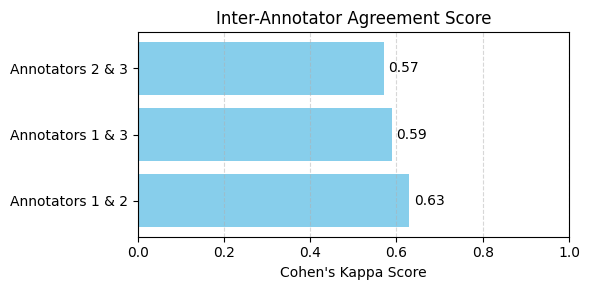

In [ ]:
import matplotlib.pyplot as plt

annotators = ['Annotators 1 & 2', 'Annotators 1 & 3', 'Annotators 2 & 3']
scores = [0.63, 0.59, 0.57]

plt.figure(figsize=(6, 3))
plt.barh(annotators, scores, color='skyblue')
plt.xlabel("Cohen's Kappa Score")
plt.title("Inter-Annotator Agreement Score")
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.5)
for i, v in enumerate(scores):
    plt.text(v + 0.01, i, f"{v:.2f}", va='center')
plt.tight_layout()
plt.show()


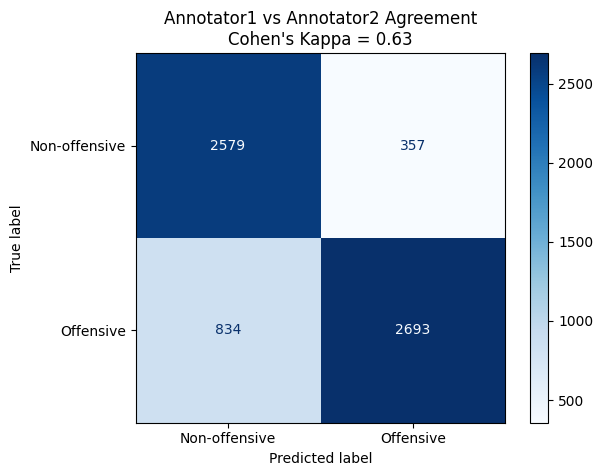

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

score = cohen_kappa_score(df_labeled['annotator1'], df_labeled['annotator2'])

# Map string labels to integers (or just use strings if you prefer)
label_list = sorted(df_labeled[['annotator1', 'annotator2']].stack().unique())
df_labeled_int = df_labeled[['annotator1', 'annotator2']].copy()

# Compute confusion matrix
cm = confusion_matrix(df_labeled_int['annotator1'], df_labeled_int['annotator2'], labels=label_list)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Annotator1 vs Annotator2 Agreement\nCohen\'s Kappa = {score:.2f}')
plt.show()

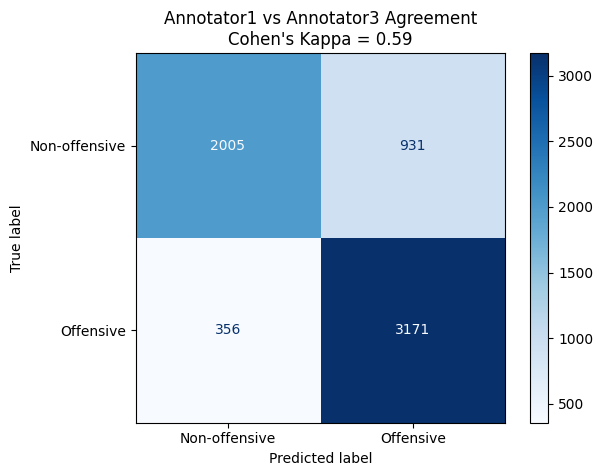

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

score = cohen_kappa_score(df_labeled['annotator1'], df_labeled['annotator3'])
# Map string labels to integers (or just use strings if you prefer)
label_list = sorted(df_labeled[['annotator1', 'annotator3']].stack().unique())
df_labeled_int = df_labeled[['annotator1', 'annotator3']].copy()

# Compute confusion matrix
cm = confusion_matrix(df_labeled_int['annotator1'], df_labeled_int['annotator3'], labels=label_list)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Annotator1 vs Annotator3 Agreement\nCohen\'s Kappa = {score:.2f}')
plt.show()

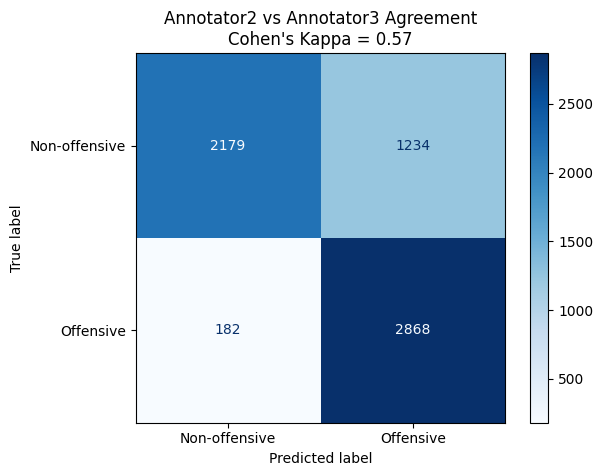

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

score = cohen_kappa_score(df_labeled['annotator2'], df_labeled['annotator3'])
# Map string labels to integers (or just use strings if you prefer)
label_list = sorted(df_labeled[['annotator2', 'annotator3']].stack().unique())
df_labeled_int = df_labeled[['annotator2', 'annotator3']].copy()

# Compute confusion matrix
cm = confusion_matrix(df_labeled_int['annotator2'], df_labeled_int['annotator3'], labels=label_list)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Annotator2 vs Annotator3 Agreement\nCohen\'s Kappa = {score:.2f}')
plt.show()

In [ ]:
df_labeled_final = df_labeled.drop(columns=['annotator1', 'annotator2', 'annotator3'])

In [ ]:
df_labeled_final.to_csv(dataset_path + 'mrp_final_labeled_dataset.csv', index=False)

In [ ]:
df_labeled_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6463 entries, 0 to 6498
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   type                       6463 non-null   object 
 1   id                         6463 non-null   int64  
 2   username                   6463 non-null   object 
 3   text                       6463 non-null   object 
 4   url                        6463 non-null   object 
 5   epoch                      6463 non-null   int64  
 6   media                      6463 non-null   object 
 7   retweetedTweet             6463 non-null   bool   
 8   retweetedTweetID           0 non-null      float64
 9   retweetedUserID            0 non-null      float64
 10  id_str                     6463 non-null   int64  
 11  lang                       6463 non-null   object 
 12  rawContent                 6463 non-null   object 
 13  replyCount                 6463 non-null   int64  
 1

In [ ]:
df_labeled_final['text'].nunique()

6463

In [ ]:
df_labeled_final['id'].nunique()

6463

In [ ]:
df_labeled_final['url'].nunique()

6463

In [ ]:
df_labeled_final['username'].nunique()

6220

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example data from your screenshot
data = {
    'Column': ['text', 'id', 'url', 'username'],
    'Unique_Count': [6463, 6463, 6463, 6220]
}

df_unique = pd.DataFrame(data)

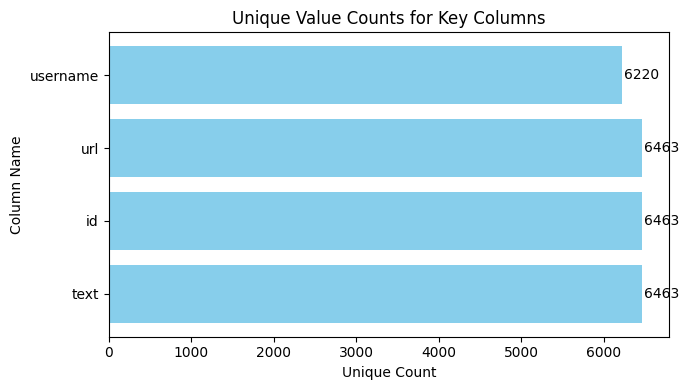

In [ ]:
plt.figure(figsize=(7, 4))
plt.barh(df_unique['Column'], df_unique['Unique_Count'], color='skyblue')
for index, value in enumerate(df_unique['Unique_Count']):
    plt.text(value + 20, index, str(value), va='center')
plt.title('Unique Value Counts for Key Columns')
plt.xlabel('Unique Count')
plt.ylabel('Column Name')
plt.tight_layout()
plt.show()


In [ ]:
df_labeled_final['retweetedTweet'].value_counts()

,count
retweetedTweet,
False,6463


In [ ]:
df_labeled_final.drop(columns=['retweetedTweetID', 'retweetedUserID', 'location', 'cash_app_handle',  'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id_str'], inplace=True)

In [ ]:
df_labeled_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6463 entries, 0 to 6498
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   type               6463 non-null   object
 1   id                 6463 non-null   int64 
 2   username           6463 non-null   object
 3   text               6463 non-null   object
 4   url                6463 non-null   object
 5   epoch              6463 non-null   int64 
 6   media              6463 non-null   object
 7   retweetedTweet     6463 non-null   bool  
 8   id_str             6463 non-null   int64 
 9   lang               6463 non-null   object
 10  rawContent         6463 non-null   object
 11  replyCount         6463 non-null   int64 
 12  retweetCount       6463 non-null   int64 
 13  likeCount          6463 non-null   int64 
 14  quoteCount         6463 non-null   int64 
 15  conversationId     6463 non-null   int64 
 16  conversationIdStr  6463 non-null   int64 
 17  

In [ ]:
df_twitter = df_labeled_final.copy()

# Label Distribution

In [ ]:
label_counts = df_twitter['majority_label'].value_counts()
label_counts

,count
majority_label,
Offensive,3584
Non-offensive,2879


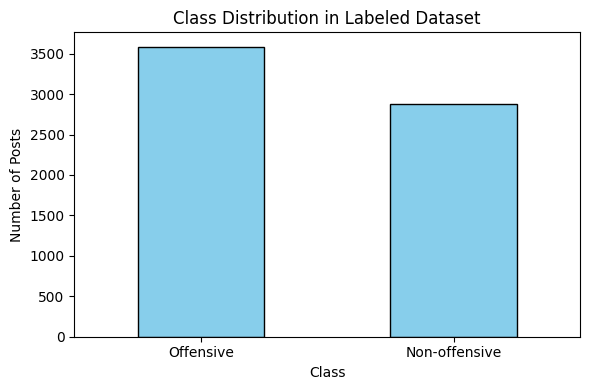

In [ ]:
import matplotlib.pyplot as plt

# Count the number of samples for each class
class_counts = df_twitter['majority_label'].value_counts()

# Plot
plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color='skyblue', edgecolor='k')
plt.title('Class Distribution in Labeled Dataset')
plt.ylabel('Number of Posts')
plt.xlabel('Class')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle=' ', alpha=0.7)
plt.tight_layout()
plt.show()

## **Observation:** The dataset is fairly balanced with 55% Offensive and 45% Non-offensive tweets

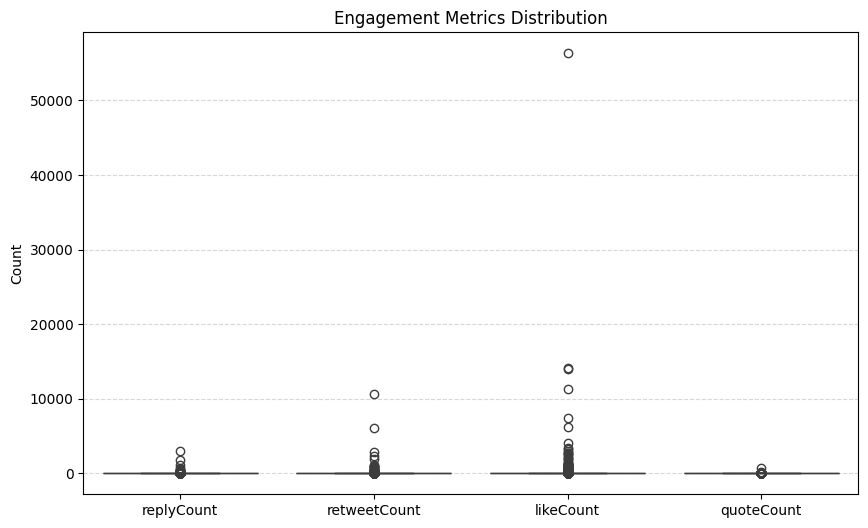

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_twitter[['replyCount', 'retweetCount', 'likeCount', 'quoteCount']])
plt.title("Engagement Metrics Distribution")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
pd.set_option('display.max_colwidth', 100)

In [ ]:
columns = ['viewCount_num', 'replyCount', 'retweetCount', 'likeCount', 'quoteCount']
df_twitter[columns].describe().round(2)

,viewCount_num,replyCount,retweetCount,likeCount,quoteCount
count,6329.0,6463.00,6463.00,6463.00,6463.00
mean,1199.85,2.37,6.73,30.30,0.36
std,34010.36,48.45,163.76,777.46,9.21
min,1.0,0.00,0.00,0.00,0.00
25%,6.0,0.00,0.00,0.00,0.00
50%,15.0,0.00,0.00,0.00,0.00
75%,45.0,0.00,0.00,1.00,0.00
max,2615574.0,3014.00,10567.00,56325.00,672.00


In [ ]:
pd.set_option('display.max_colwidth', 100)

In [ ]:
df_twitter[df_twitter['viewCount_num'] > 200000][['text','viewCount_num', 'likeCount', 'replyCount', 'retweetCount', 'quoteCount', 'majority_label']].sort_values(by='viewCount_num', ascending=False)

,text,viewCount_num,likeCount,replyCount,retweetCount,quoteCount,majority_label
1579,BREAKING Multibillionaire owner Arthur Blank announces his support for Kamala Harris to be the n...,2615574,56325,3014,10567,672,Non-offensive
4881,Kamala Harris depicted chained up behind golf cart during Pennsylvania Halloween parade CBS Pitt...,299852,518,200,403,174,Non-offensive
5266,Feminist author and exClinton advisor endorses Donald Trump for president The people I voted for...,260995,11258,79,2911,85,Offensive
5483,gtHarris lies saying she worked at McDonalds gthe works a McDonalds gtBiden calls his supporters...,242774,14168,79,926,17,Offensive
2987,IRS Whistleblowers Involved in Hunter Biden Tax Case Reveal IRS DOJ and FBI Knew Laptop Was Real...,221969,7429,71,2304,90,Non-offensive
5503,Anyone catch Bidens panda eyes Halloween gig tonight There is a reason Trump says these people a...,216005,913,53,437,74,Offensive


In [ ]:
df_twitter[df_twitter['likeCount'] > 10000][['text','viewCount_num', 'likeCount', 'replyCount', 'retweetCount', 'quoteCount', 'majority_label']].sort_values(by='likeCount', ascending=False)

,text,viewCount_num,likeCount,replyCount,retweetCount,quoteCount,majority_label
1579,BREAKING Multibillionaire owner Arthur Blank announces his support for Kamala Harris to be the n...,2615574,56325,3014,10567,672,Non-offensive
5483,gtHarris lies saying she worked at McDonalds gthe works a McDonalds gtBiden calls his supporters...,242774,14168,79,926,17,Offensive
4793,If you are a journalist covering this election fairly you have a duty to report on Donald Trumps...,163031,14040,278,6050,84,Offensive
5266,Feminist author and exClinton advisor endorses Donald Trump for president The people I voted for...,260995,11258,79,2911,85,Offensive


In [ ]:
df_twitter[df_twitter['retweetCount'] > 2000][['text','viewCount_num','retweetCount', 'replyCount', 'likeCount', 'quoteCount', 'majority_label']].sort_values(by='retweetCount', ascending=False)

,text,viewCount_num,retweetCount,replyCount,likeCount,quoteCount,majority_label
1579,BREAKING Multibillionaire owner Arthur Blank announces his support for Kamala Harris to be the n...,2615574,10567,3014,56325,672,Non-offensive
4793,If you are a journalist covering this election fairly you have a duty to report on Donald Trumps...,163031,6050,278,14040,84,Offensive
5266,Feminist author and exClinton advisor endorses Donald Trump for president The people I voted for...,260995,2911,79,11258,85,Offensive
2987,IRS Whistleblowers Involved in Hunter Biden Tax Case Reveal IRS DOJ and FBI Knew Laptop Was Real...,221969,2304,71,7429,90,Non-offensive


In [ ]:
df_twitter[df_twitter['replyCount'] > 1000][['text','viewCount_num','replyCount', 'retweetCount', 'likeCount', 'quoteCount']].sort_values(by='replyCount', ascending=False)

,text,viewCount_num,replyCount,retweetCount,likeCount,quoteCount
1579,BREAKING Multibillionaire owner Arthur Blank announces his support for Kamala Harris to be the n...,2615574,3014,10567,56325,672
3403,BREAKING President Trump says the hosts of The View are degenerates and dumb women Do you agree ...,40486,1717,430,4047,85
3076,Lebron James has officially endorsed Kamala Harris today Does this change your vote,90689,1168,737,2704,84


In [ ]:
df_twitter[df_twitter['quoteCount'] > 85][['text','viewCount_num','quoteCount', 'replyCount', 'retweetCount', 'likeCount']].sort_values(by='quoteCount', ascending=False)

,text,viewCount_num,quoteCount,replyCount,retweetCount,likeCount
1579,BREAKING Multibillionaire owner Arthur Blank announces his support for Kamala Harris to be the n...,2615574,672,3014,10567,56325
4881,Kamala Harris depicted chained up behind golf cart during Pennsylvania Halloween parade CBS Pitt...,299852,174,200,403,518
2987,IRS Whistleblowers Involved in Hunter Biden Tax Case Reveal IRS DOJ and FBI Knew Laptop Was Real...,221969,90,71,2304,7429
5329,No one can EVER again doubt the power and brilliance of President Joe Biden He cunningly pulled ...,55213,86,213,785,2220


In [ ]:
pd.set_option('display.max_colwidth', None)
df_twitter.iloc[1579]

,1590
type,tweet-
id,1843849905422643458
username,ZBreakingNewz
text,Team Trump Demands Minutes Release Kamala Harriss Unedited Full Interview Transcript The Trump campaign called on CBS Newss Minutes to release its full unedited transcript with Vice President Kamala Harris The post Team
url,https://twitter.com/ZBreakingNewz/status/1843849905422643458
epoch,1728443049
media,"[{'display_url': 'pic.x.com/GfpVuEN59H', 'expanded_url': 'https://x.com/ZBreakingNewz/status/1843849905422643458/photo/1', 'id_str': '1843849903593963520', 'indices': [275, 298], 'media_key': '3_1843849903593963520', 'media_url_https': 'https://pbs.twimg.com/media/GZart9rbQAA7wix.jpg', 'type': 'photo', 'url': 'https://t.co/GfpVuEN59H', 'ext_media_availability': {'status': 'Available'}, 'features': {'large': {'faces': [{'x': 287, 'y': 99, 'h': 138, 'w': 138}]}, 'medium': {'faces': [{'x': 287, 'y': 99, 'h': 138, 'w': 138}]}, 'small': {'faces': [{'x': 287, 'y': 99, 'h': 138, 'w': 138}]}, 'orig': {'faces': [{'x': 287, 'y': 99, 'h': 138, 'w': 138}]}}, 'sizes': {'large': {'h': 335, 'w': 640, 'resize': 'fit'}, 'medium': {'h': 335, 'w': 640, 'resize': 'fit'}, 'small': {'h': 335, 'w': 640, 'resize': 'fit'}, 'thumb': {'h': 150, 'w': 150, 'resize': 'crop'}}, 'original_info': {'height': 335, 'width': 640, 'focus_rects': [{'x': 36, 'y': 0, 'w': 598, 'h': 335}, {'x': 168, 'y': 0, 'w': 335, 'h': 335}, {'x': 188, 'y': 0, 'w': 294, 'h': 335}, {'x': 251, 'y': 0, 'w': 168, 'h': 335}, {'x': 0, 'y': 0, 'w': 640, 'h': 335}]}, 'media_results': {'result': {'media_key': '3_1843849903593963520'}}}]"
retweetedTweet,False
id_str,1843849905422643458
lang,en


In [ ]:
pd.set_option('display.max_colwidth', 100)

In [ ]:
df_twitter[df_twitter['viewCount_num'] > 200000][['text','viewCount_num']].sort_values(by='viewCount_num', ascending=False)

,text,viewCount_num
1579,BREAKING Multibillionaire owner Arthur Blank announces his support for Kamala Harris to be the n...,2615574
4881,Kamala Harris depicted chained up behind golf cart during Pennsylvania Halloween parade CBS Pitt...,299852
5266,Feminist author and exClinton advisor endorses Donald Trump for president The people I voted for...,260995
5483,gtHarris lies saying she worked at McDonalds gthe works a McDonalds gtBiden calls his supporters...,242774
2987,IRS Whistleblowers Involved in Hunter Biden Tax Case Reveal IRS DOJ and FBI Knew Laptop Was Real...,221969
5503,Anyone catch Bidens panda eyes Halloween gig tonight There is a reason Trump says these people a...,216005


In [ ]:
label_means = df_twitter.groupby('majority_label')[
    ['viewCount_num', 'replyCount', 'retweetCount', 'likeCount', 'quoteCount']
].mean().round(2)

display(label_means)

,viewCount_num,replyCount,retweetCount,likeCount,quoteCount
majority_label,,,,,
Non-offensive,1957.94,3.33,8.01,39.20,0.55
Offensive,586.71,1.59,5.69,23.16,0.21


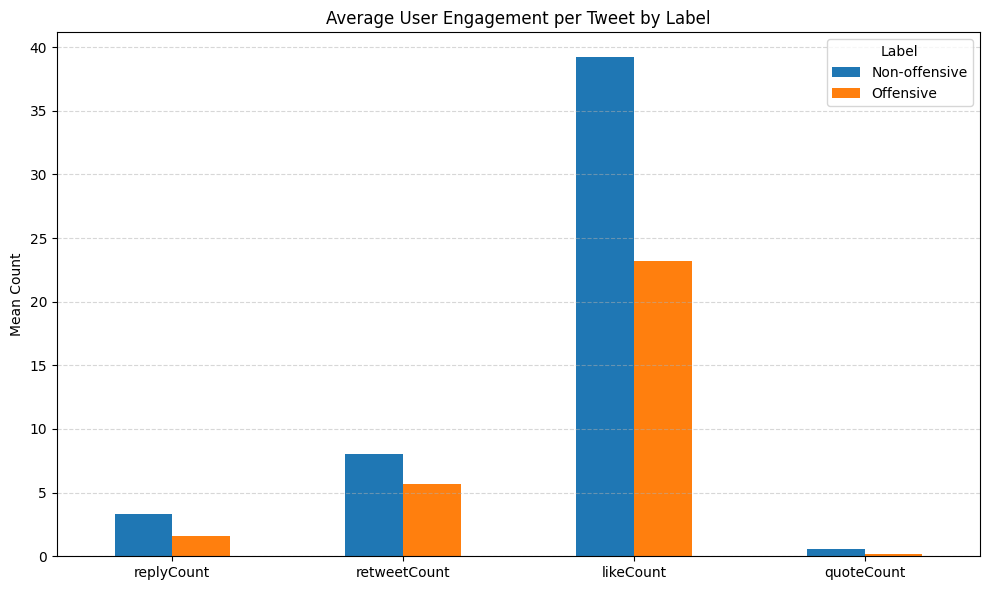

In [ ]:
import matplotlib.pyplot as plt

# Group by label and calculate mean for each metric
label_means = df_twitter.groupby('majority_label')[['replyCount', 'retweetCount', 'likeCount', 'quoteCount']].mean()

# Plot as a bar chart
label_means.T.plot(kind='bar', figsize=(10, 6))
plt.title("Average User Engagement per Tweet by Label")
plt.ylabel("Mean Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Label')
plt.tight_layout()
plt.show()


# Text Length - Word Count

In [ ]:
import pandas as pd
dataset_path = "/content/drive/MyDrive/MRP_Offensive_Content_Detection/Final_Dataset/"

In [ ]:
df_twitter = pd.read_csv(dataset_path + 'mrp_final_labeled_dataset.csv')

In [ ]:
df_twitter['word_length'] = df_twitter['text'].astype(str).apply(lambda x: len(x.split()))

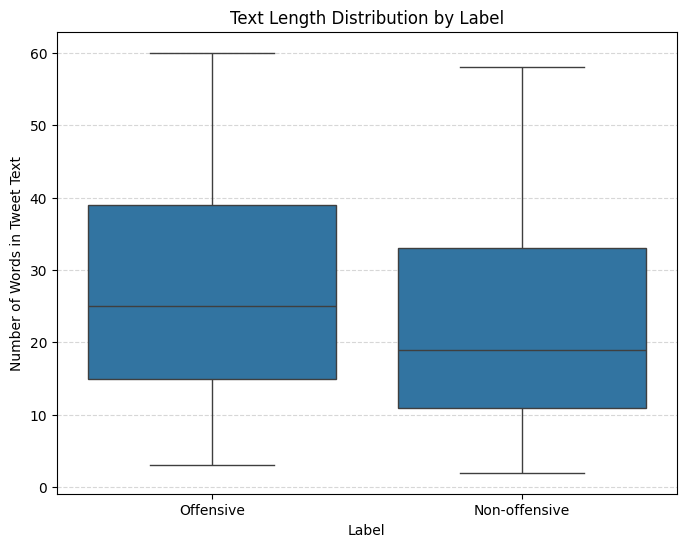

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(x='majority_label', y='word_length', data=df_twitter)
plt.title('Text Length Distribution by Label')
plt.xlabel('Label')
plt.ylabel('Number of Words in Tweet Text')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

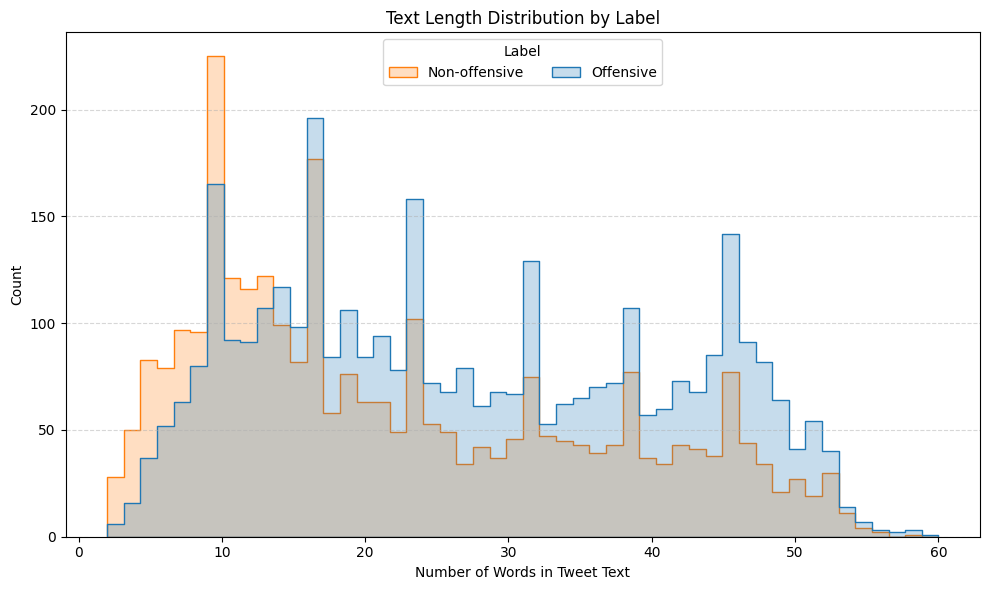

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Overlaid histograms by label
sns.histplot(data=df_twitter, x='word_length', hue='majority_label', bins=50, kde=False, element='step', stat='count')

# Set title and axis labels
plt.title("Text Length Distribution by Label")
plt.xlabel("Number of Words in Tweet Text")
plt.ylabel("Count")

# Set legend title and location at top
plt.legend(title='Label', labels=['Non-offensive', 'Offensive'], loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=2)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
short_texts = df_twitter[df_twitter['word_length'] <= 2]
print(short_texts[['text', 'word_length', 'majority_label']])

                     text  word_length majority_label
146     Thank BidenHarris            2  Non-offensive
2044           Love Trump            2  Non-offensive
2141           Mary Biden            2  Non-offensive
2227         Welcome MAGA            2  Non-offensive
2467  Voting conservative            2  Non-offensive
5189   Conservative Korea            2  Non-offensive
5980        ADonald Trump            2  Non-offensive


In [ ]:
print(df_twitter['word_length'].describe())

count    6463.000000
mean       25.036825
std        13.958051
min         2.000000
25%        13.000000
50%        22.000000
75%        37.000000
max        60.000000
Name: word_length, dtype: float64


In [ ]:
print(df_twitter.groupby('majority_label')['word_length'].describe())

                 count       mean        std  min   25%   50%   75%   max
majority_label                                                           
Non-offensive   2879.0  22.368878  13.750131  2.0  11.0  19.0  33.0  58.0
Offensive       3584.0  27.179967  13.754830  3.0  15.0  25.0  39.0  60.0


In [ ]:
print("Text Length Statistics by Label")
summary_df = df_twitter.groupby('majority_label')['word_length'].describe().round(2)
display(summary_df)  # or summary_df.to_markdown() for markdown export

Text Length Statistics by Label


,count,mean,std,min,25%,50%,75%,max
majority_label,,,,,,,,
Non-offensive,2879.0,22.37,13.75,2.0,11.0,19.0,33.0,58.0
Offensive,3584.0,27.18,13.75,3.0,15.0,25.0,39.0,60.0


# Tweets by date

In [ ]:
df = df_twitter.copy()
df['majority_label'] = df['majority_label'].map({'Offensive': 1, 'Non-offensive': 0})
df['date'] = pd.to_datetime(df['date'])

# Group by date (at daily granularity) and count
tweets_per_date = df.groupby(df['date'].dt.date).size().reset_index(name='num_tweets')

# Print as a DataFrame
print(tweets_per_date)

         date  num_tweets
0  2024-10-09         989
1  2024-10-10         405
2  2024-10-12         394
3  2024-10-13         390
4  2024-10-28         462
5  2024-10-29        1239
6  2024-10-30        1446
7  2024-10-31        1138


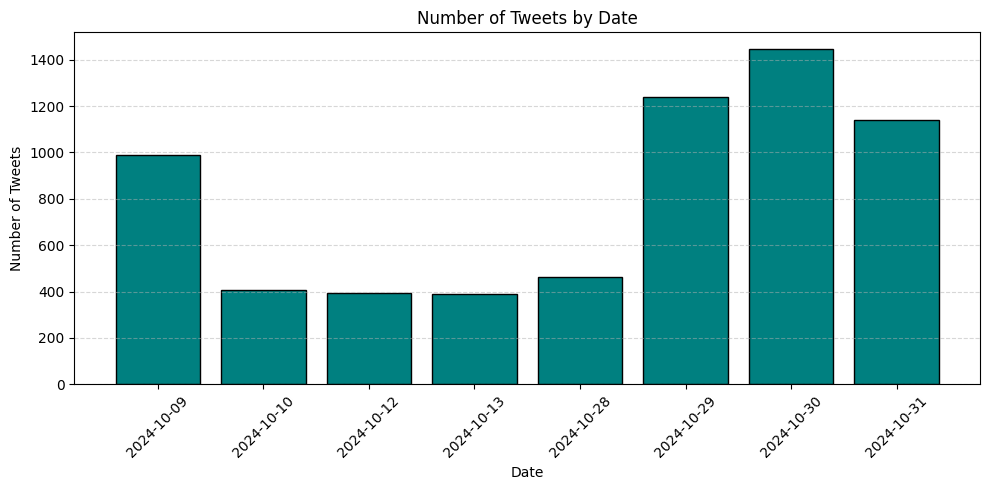

In [ ]:
# Group by date and count
tweets_per_date = df.groupby(df['date'].dt.date).size().reset_index(name='num_tweets')

plt.figure(figsize=(10, 5))
plt.bar(tweets_per_date['date'].astype(str), tweets_per_date['num_tweets'], color='teal', edgecolor='k')
plt.title('Number of Tweets by Date')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Most (59%) of tweets in labeled datset are from 29 to 31 October

# Wordcloud for Labeled dataset

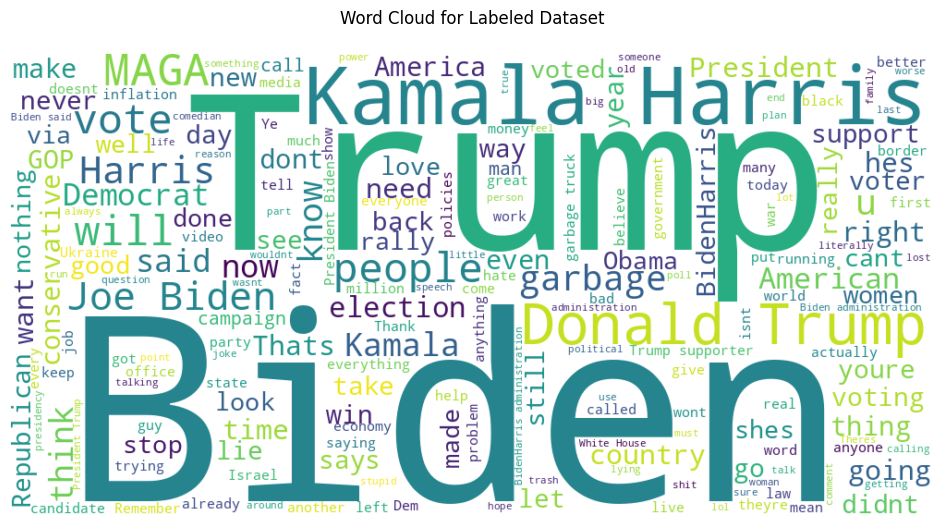

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text entries into one string
text = " ".join(df_twitter['text'].dropna().astype(str))
from wordcloud import STOPWORDS

custom_stopwords = set(STOPWORDS).union({'amp', 'im', 'like', 'just', 'that', 'say', 'one'})

# Create and configure the word cloud
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    stopwords=custom_stopwords,  # Removes common English stopwords
    collocations=True      # Keeps common word pairs
).generate(text)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Labeled Dataset\n")
plt.show()

# Keywords in text column

In [ ]:
df_twitter['matched_keywords'].value_counts()

,count
matched_keywords,
['Biden'],1787
"['Donald Trump', 'Trump', 'Donald']",804
"['Kamala Harris', 'Kamala']",714
"['Biden', 'Trump']",601
['MAGA'],397
...,...
"['Biden', 'conservative', 'Kamala']",1
"['Trump', 'Joe', 'Kamala']",1
"['GOP', 'Kamala Harris', 'Kamala']",1


In [ ]:
df = df_twitter.copy()
import ast

# Convert string to actual list
df['matched_keywords'] = df['matched_keywords'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x
)

# Replace synonyms
replace_map = {
    'Kamala': 'Kamala Harris',
    'Harris': 'Kamala Harris',
    'Biden': 'Joe Biden',
    'Joe': 'Joe Biden',
    'Joseph Biden': 'Joe Biden',
    'Donald': 'Donald Trump',
    'Trump': 'Donald Trump'
}

def replace_keywords(keywords):
    if isinstance(keywords, list):
        return [replace_map.get(word, word) for word in keywords]
    return keywords

df['matched_keywords'] = df['matched_keywords'].apply(replace_keywords)

# Remove duplicates within each list
df['matched_keywords'] = df['matched_keywords'].apply(
    lambda x: list(set(x)) if isinstance(x, list) else x
)

# Join back to string for inspection
df['matched_keywords_clean'] = df['matched_keywords'].apply(
    lambda x: ', '.join(x) if isinstance(x, list) else x
)

# Explode for analysis
df_keywords = df.explode('matched_keywords')
df_keywords['keyword'] = df_keywords['matched_keywords'].str.strip()

# Count frequency
keyword_counts = df_keywords['keyword'].value_counts()
print(keyword_counts)

keyword
Joe Biden                      3316
Donald Trump                   2438
Kamala Harris                  1509
MAGA                            648
conservative                    204
GOP                             182
DNC                              56
Democratic party                 39
US Elections                     33
Ron DeSantis                     29
MAKE AMERICA GREAT AGAIN         19
RNC                              14
Republican party                 14
Joe Biden and Kamala Harris      14
Nikki Haley                      10
RFK Jr                            8
Jill Stein                        8
KAG                               7
Third Party                       7
Vivek Ramaswamy                   4
Green Party                       4
Name: count, dtype: int64


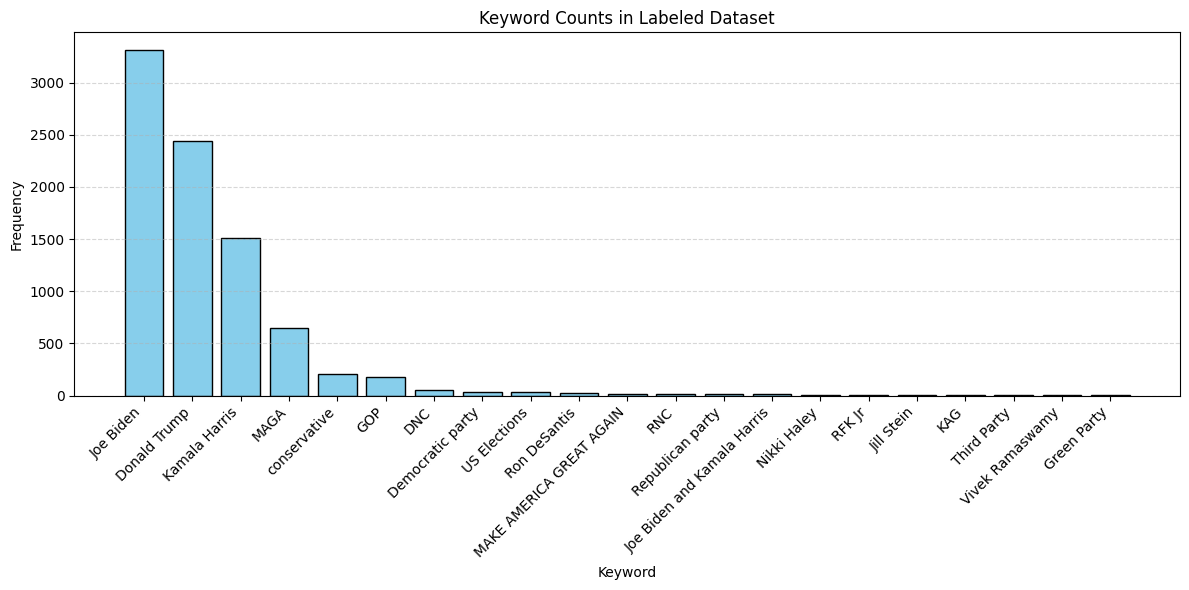

In [ ]:
# Convert to DataFrame
df_keywords = pd.DataFrame(list(keyword_counts.items()), columns=['keyword', 'count'])

plt.figure(figsize=(12, 6))
plt.bar(df_keywords['keyword'], df_keywords['count'], color='skyblue', edgecolor='k')
plt.title('Keyword Counts in Labeled Dataset')
plt.ylabel('Frequency')
plt.xlabel('Keyword')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Make sure the index of df is unique
df_copy = df.reset_index(drop=True)

# Explode matched_keywords
df_keywords = df_copy.explode('matched_keywords')

# Clean up keyword
df_keywords['keyword'] = df_keywords['matched_keywords'].astype(str).str.replace(r'[\[\]\'\"]', '', regex=True).str.strip()

# Keep the original label
df_keywords['label'] = df_copy['majority_label']

# print(df_keywords.head())
# Group and count
keyword_label_counts = df_keywords.groupby(['keyword', 'label']).size().unstack(fill_value=0)

In [ ]:
# Sum across the label columns to get total count per keyword
keyword_label_counts['total'] = keyword_label_counts.sum(axis=1)

# Sort by 'total' in descending order
keyword_label_counts_sorted = keyword_label_counts.sort_values(by='total', ascending=False)
# keyword_label_counts_sorted = keyword_label_counts_sorted.drop(columns='total')
print(keyword_label_counts_sorted)

label                        Non-offensive  Offensive  total
keyword                                                     
Joe Biden                             1280       2036   3316
Donald Trump                          1167       1271   2438
Kamala Harris                          665        844   1509
MAGA                                   266        382    648
conservative                           125         79    204
GOP                                     93         89    182
DNC                                     25         31     56
Democratic party                         7         32     39
US Elections                            27          6     33
Ron DeSantis                            15         14     29
MAKE AMERICA GREAT AGAIN                13          6     19
Republican party                         7          7     14
Joe Biden and Kamala Harris              5          9     14
RNC                                     10          4     14
Nikki Haley             

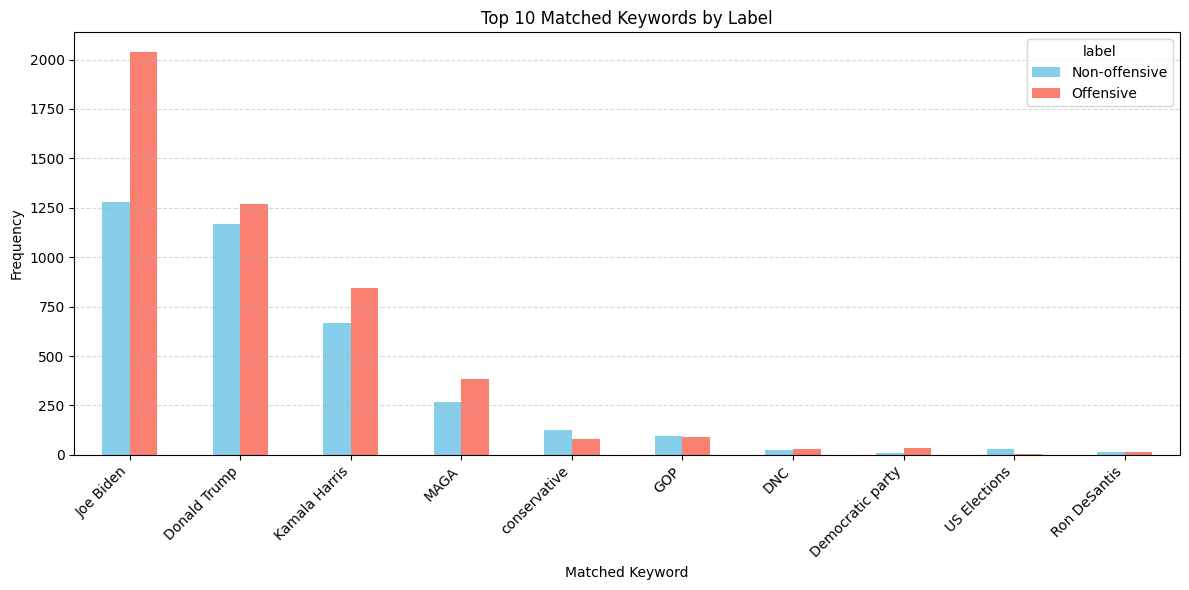

In [ ]:
import matplotlib.pyplot as plt

# Drop the 'total' column for plotting
df_plot = keyword_label_counts_sorted.drop(columns='total').head(10)

# Plot as stacked bar chart
df_plot.plot(kind='bar', stacked=False, figsize=(12, 6), color=['skyblue', 'salmon'])
plt.title('Top 10 Matched Keywords by Label')
plt.ylabel('Frequency')
plt.xlabel('Matched Keyword')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 1.2.4 Common bigrams/trigrams
- Are there specific words/phrases tied to hate speech?

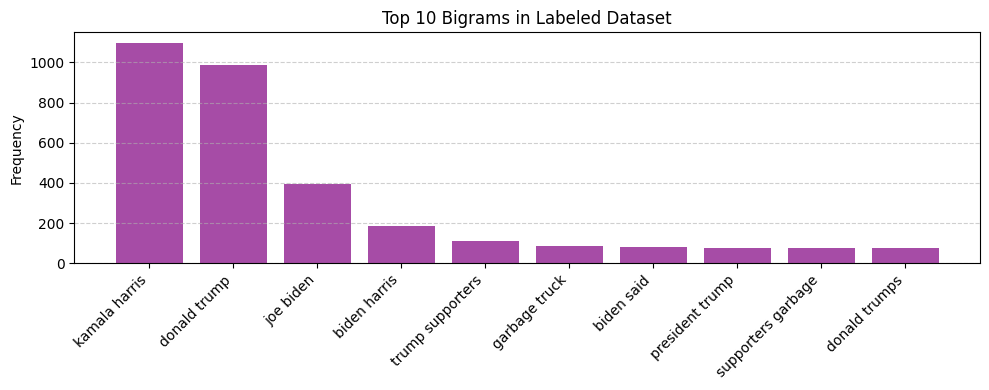

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Get bigrams
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
X = vectorizer.fit_transform(df_twitter['text'].astype(str))

# Sum up counts of each bigram
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Plot top 10 bigrams
top_bigrams = words_freq[:10]
bigrams, counts = zip(*top_bigrams)

plt.figure(figsize=(10, 4))
plt.bar(bigrams, counts, color='purple', alpha=0.7)
plt.title('Top 10 Bigrams in Labeled Dataset')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Top 10 bigrams in each class

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Ensure text is string
df_twitter['text'] = df_twitter['text'].astype(str)

# Function to get top bigrams
def get_top_ngrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2,2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

    return words_freq[:n]

# Get top bigrams for each class
# Get offensive and non-offensive subsets
offensive_corpus = df_twitter[df_twitter['majority_label'] == 'Offensive']['text']
non_offensive_corpus = df_twitter[df_twitter['majority_label'] == 'Non-offensive']['text']

# Get top 10 bigrams
top_bigrams_offensive = get_top_ngrams(offensive_corpus, n=10)
top_bigrams_non_offensive = get_top_ngrams(non_offensive_corpus, n=10)


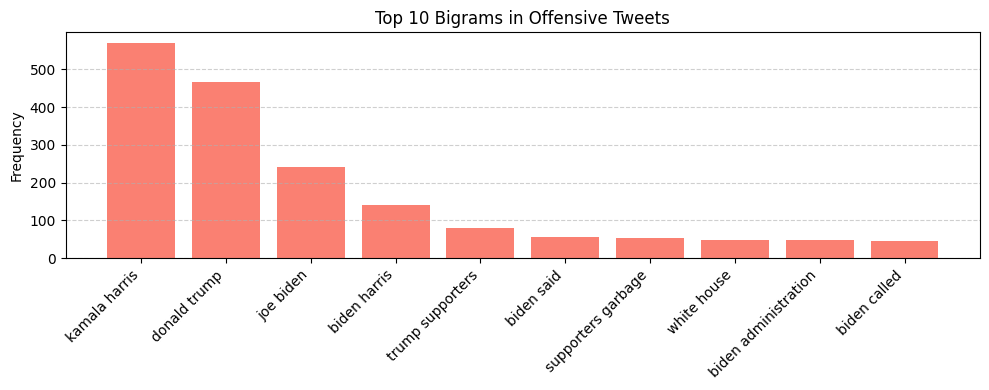

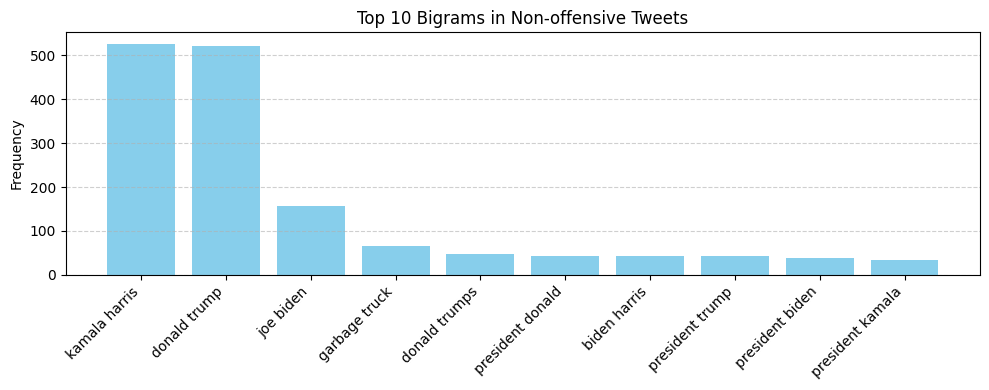

In [ ]:
def plot_top_bigrams(bigrams, title, barcolor):
    bigrams, counts = zip(*bigrams)
    plt.figure(figsize=(10, 4))
    plt.bar(bigrams, counts, color=barcolor)
    plt.title(title)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Offensive bigrams
plot_top_bigrams(top_bigrams_offensive, "Top 10 Bigrams in Offensive Tweets", 'salmon')

# Non-offensive bigrams
plot_top_bigrams(top_bigrams_non_offensive, "Top 10 Bigrams in Non-offensive Tweets", 'skyblue')


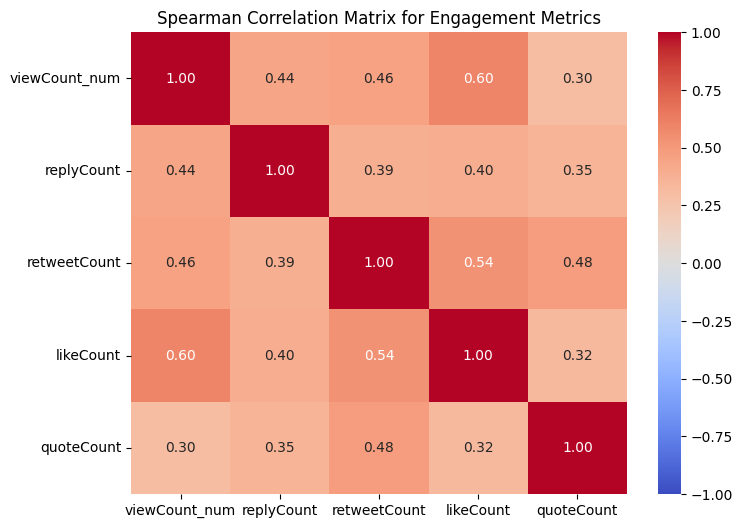

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select engagement metrics
metrics = ['viewCount_num', 'replyCount', 'retweetCount', 'likeCount', 'quoteCount']

# Compute Spearman correlation matrix
spearman_corr = df_twitter[metrics].corr(method='spearman')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Spearman Correlation Matrix for Engagement Metrics')
plt.show()


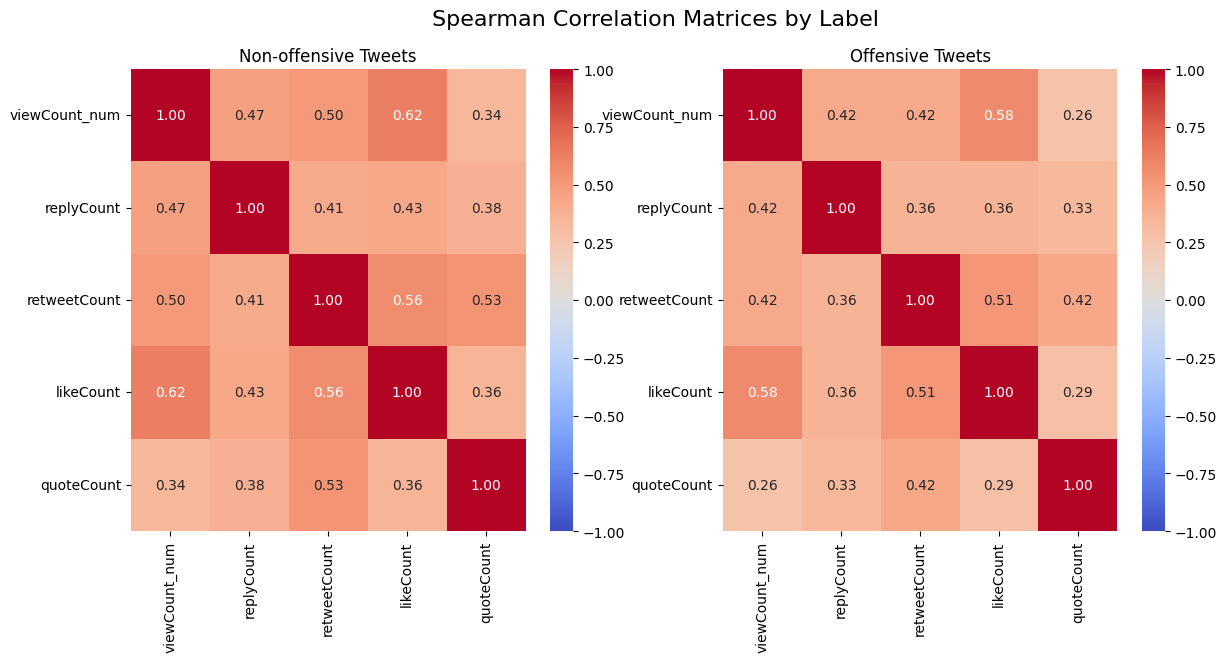

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

metrics = ['viewCount_num', 'replyCount', 'retweetCount', 'likeCount', 'quoteCount']

# Separate datasets
offensive_df = df_twitter[df_twitter['majority_label'] == 'Offensive']
non_offensive_df = df_twitter[df_twitter['majority_label'] == 'Non-offensive']

# Compute Spearman correlation
off_corr = offensive_df[metrics].corr(method='spearman')
non_corr = non_offensive_df[metrics].corr(method='spearman')

# Plot side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(non_corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title('Non-offensive Tweets')

sns.heatmap(off_corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title('Offensive Tweets')

plt.suptitle('Spearman Correlation Matrices by Label', fontsize=16)
plt.show()
